[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

In [3]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(176, 13)

(array([ 4.,  6., 17., 15., 16., 29., 40., 33., 14.,  2.]),
 array([-2.43313965, -2.00169637, -1.57025309, -1.13880982, -0.70736654,
        -0.27592326,  0.15552001,  0.58696329,  1.01840657,  1.44984984,
         1.88129312]),
 <a list of 10 Patch objects>)

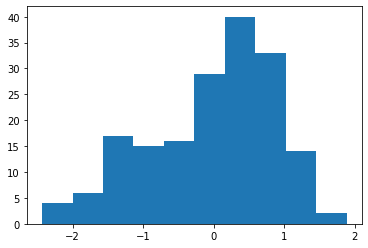

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score]

gpr = GPR_Predictor(df, kernel_name = kernel)

In [7]:
# test para
# num_split = 5
# num_repeat = 2
# s_list = [0]
# # alpha_list = [0.5]
# alpha_list= [2]
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list = [6] 
# sigma_0_list = [1,2]

In [8]:
num_split = 5
num_repeat = 10
s_list = [1]
# alpha_list = [0.5]
alpha_list= [0, 1e-5, 1e-1, 1, 2, 5, 10] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list = [6]
sigma_0_list = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                      l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=2450)

init kernel
1
init kernel
2
init kernel
3
init kernel
4
init kernel
5
init kernel
6
init kernel
7
init kernel
8
init kernel
9
init kernel
10
init kernel
11
init kernel
12
init kernel
13
init kernel
14
init kernel
15
init kernel
16
init kernel
17
init kernel
18
init kernel
19
init kernel
20
init kernel
21
init kernel
22
init kernel
23
init kernel
24
init kernel
25
init kernel
26
init kernel
27
init kernel
28
init kernel
29
init kernel
30
init kernel
31
init kernel
32
init kernel
33
init kernel
34
init kernel
35
init kernel
36
init kernel
37
init kernel
38
init kernel
39
init kernel
40
init kernel
41
init kernel
42
init kernel
43
init kernel
44
init kernel
45
init kernel
46
init kernel
47
init kernel
48
init kernel
49
init kernel
50
init kernel
51
init kernel
52
init kernel
53
init kernel
54
init kernel
55
init kernel
56
init kernel
57
init kernel
58
init kernel
59
init kernel
60
init kernel
61
init kernel
62
init kernel
63
init kernel
64
init kernel
65
init kernel
66
init kernel
67
init

init kernel
520
init kernel
521
init kernel
522
init kernel
523
init kernel
524
init kernel
525
init kernel
526
init kernel
527
init kernel
528
init kernel
529
init kernel
530
init kernel
531
init kernel
532
init kernel
533
init kernel
534
init kernel
535
init kernel
536
init kernel
537
init kernel
538
init kernel
539
init kernel
540
init kernel
541
init kernel
542
init kernel
543
init kernel
544
init kernel
545
init kernel
546
init kernel
547
init kernel
548
init kernel
549
init kernel
550
init kernel
551
init kernel
552
init kernel
553
init kernel
554
init kernel
555
init kernel
556
init kernel
557
init kernel
558
init kernel
559
init kernel
560
init kernel
561
init kernel
562
init kernel
563
init kernel
564
init kernel
565
init kernel
566
init kernel
567
init kernel
568
init kernel
569
init kernel
570
init kernel
571
init kernel
572
init kernel
573
init kernel
574
init kernel
575
init kernel
576
init kernel
577
init kernel
578
init kernel
579
init kernel
580
init kernel
581
init ker

1030
init kernel
1031
init kernel
1032
init kernel
1033
init kernel
1034
init kernel
1035
init kernel
1036
init kernel
1037
init kernel
1038
init kernel
1039
init kernel
1040
init kernel
1041
init kernel
1042
init kernel
1043
init kernel
1044
init kernel
1045
init kernel
1046
init kernel
1047
init kernel
1048
init kernel
1049
init kernel
1050
init kernel
1051
init kernel
1052
init kernel
1053
init kernel
1054
init kernel
1055
init kernel
1056
init kernel
1057
init kernel
1058
init kernel
1059
init kernel
1060
init kernel
1061
init kernel
1062
init kernel
1063
init kernel
1064
init kernel
1065
init kernel
1066
init kernel
1067
init kernel
1068
init kernel
1069
init kernel
1070
init kernel
1071
init kernel
1072
init kernel
1073
init kernel
1074
init kernel
1075
init kernel
1076
init kernel
1077
init kernel
1078
init kernel
1079
init kernel
1080
init kernel
1081
init kernel
1082
init kernel
1083
init kernel
1084
init kernel
1085
init kernel
1086
init kernel
1087
init kernel
1088
init kern

1512
init kernel
1513
init kernel
1514
init kernel
1515
init kernel
1516
init kernel
1517
init kernel
1518
init kernel
1519
init kernel
1520
init kernel
1521
init kernel
1522
init kernel
1523
init kernel
1524
init kernel
1525
init kernel
1526
init kernel
1527
init kernel
1528
init kernel
1529
init kernel
1530
init kernel
1531
init kernel
1532
init kernel
1533
init kernel
1534
init kernel
1535
init kernel
1536
init kernel
1537
init kernel
1538
init kernel
1539
init kernel
1540
init kernel
1541
init kernel
1542
init kernel
1543
init kernel
1544
init kernel
1545
init kernel
1546
init kernel
1547
init kernel
1548
init kernel
1549
init kernel
1550
init kernel
1551
init kernel
1552
init kernel
1553
init kernel
1554
init kernel
1555
init kernel
1556
init kernel
1557
init kernel
1558
init kernel
1559
init kernel
1560
init kernel
1561
init kernel
1562
init kernel
1563
init kernel
1564
init kernel
1565
init kernel
1566
init kernel
1567
init kernel
1568
init kernel
1569
init kernel
1570
init kern

1994
init kernel
1995
init kernel
1996
init kernel
1997
init kernel
1998
init kernel
1999
init kernel
2000
init kernel
2001
init kernel
2002
init kernel
2003
init kernel
2004
init kernel
2005
init kernel
2006
init kernel
2007
init kernel
2008
init kernel
2009
init kernel
2010
init kernel
2011
init kernel
2012
init kernel
2013
init kernel
2014
init kernel
2015
init kernel
2016
init kernel
2017
init kernel
2018
init kernel
2019
init kernel
2020
init kernel
2021
init kernel
2022
init kernel
2023
init kernel
2024
init kernel
2025
init kernel
2026
init kernel
2027
init kernel
2028
init kernel
2029
init kernel
2030
init kernel
2031
init kernel
2032
init kernel
2033
init kernel
2034
init kernel
2035
init kernel
2036
init kernel
2037
init kernel
2038
init kernel
2039
init kernel
2040
init kernel
2041
init kernel
2042
init kernel
2043
init kernel
2044
init kernel
2045
init kernel
2046
init kernel
2047
init kernel
2048
init kernel
2049
init kernel
2050
init kernel
2051
init kernel
2052
init kern

In [9]:
import pickle

with open('repeated_kfold_wd_shift_with_signal_std.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('repeated_kfold_wd_shift_with_signal_std.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
result_pkl.loc[dict(train_test = 'Test')]

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 7, l: 1, s: 1, sigma_0: 7, num_repeat: 10, num_split: 5)>
array([[[[[[[[ 9.13274562e-01,  1.29739102e+00,  7.79960002e-01,
               5.98178392e-01,  9.22800917e-01],
             [ 1.11534295e+00,  1.10263215e+00,  7.43103027e-01,
               8.64741343e-01,  9.96709601e-01],
             [ 1.45147427e+00,  9.04722079e-01,  5.75134340e-01,
               8.00965489e-01,  5.61396060e-01],
             ...,
             [ 1.26973338e+00,  5.36797280e-01,  8.74623080e-01,
               8.43639933e-01,  8.15504278e-01],
             [ 6.44934491e-01,  1.04205128e+00,  1.38118826e+00,
               1.00101580e+00,  7.81001406e-01],
             [ 9.59906875e-01,  1.05900200e+00,  9.69461609e-01,
               8.58676819e-01,  1.08241521e+00]],

            [[ 7.21266847e-01,  1.12999251e+00,  9.54205200e-01,
               8.12653988e-01,  1.01359654e+00],
             [ 9.80019884e-01,  1.05176014e+00,  1.00393733e+00,
               9.22915457e-01,  7.02538254e-01],
             [ 8.34893487e-01,  8.98282722e-01,  1.09531822e+00,
               1.07898739e+00,  6.86690727e-01],
...
             [-2.56954121e-02, -1.06246476e-01,  3.73846652e-01,
               2.62165672e-01,  3.00200702e-01],
             [ 2.43439190e-01,  3.64149730e-01,  9.01411541e-02,
               4.32728243e-01,  1.74949246e-01],
             [ 1.16539732e-01,  2.77152936e-01,  1.29889165e-01,
               1.38260813e-01,  4.52143395e-01]],

            [[ 1.62775897e-01,  1.44525571e-01,  2.16655893e-01,
               2.48308261e-01,  3.11529028e-01],
             [ 9.42923882e-02,  2.21279351e-01,  1.81126815e-01,
               4.31067564e-01,  6.44775922e-02],
             [ 3.59051444e-01, -6.55954931e-03,  2.31333325e-01,
               2.21559544e-01, -3.54363931e-02],
             ...,
             [ 2.81322246e-01,  1.74984618e-01,  1.47241382e-01,
               9.84707429e-02,  3.21935967e-01],
             [ 2.30859722e-01,  1.23786849e-01,  2.08965784e-01,
               2.54127029e-01,  2.97332362e-01],
             [-4.44392542e-02,  1.85452438e-01,  3.73608303e-01,
               1.65885046e-01,  3.81107365e-01]]]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7f29f36...
  * alpha       (alpha) float64 0.0 1e-05 0.1 1.0 2.0 5.0 10.0
  * l           (l) int64 6
  * s           (s) int64 1
  * sigma_0     (sigma_0) float64 0.5 0.75 1.0 1.25 1.5 1.75 2.0
  * num_repeat  (num_repeat) int64 0 1 2 3 4 5 6 7 8 9
  * num_split   (num_split) int64 0 1 2 3 4

In [11]:
result_pkl[1].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (eva_on: 2, eva_metric: 2, alpha: 7, l: 1, s: 1, sigma_0: 7)>
array([[[[[[ 0.91715737,  0.95558752,  0.94907447,  0.97653319,
             0.99860396,  1.00933593,  1.00552227]]],


         [[[ 0.92667712,  0.98920109,  0.97808997,  0.98754391,
             0.98593567,  0.95840682,  1.01441908]]],


         [[[ 0.92815064,  0.95363386,  0.96773074,  0.98253636,
             0.99614354,  0.98398041,  1.03118722]]],


         [[[ 0.86186842,  0.87673158,  0.85192782,  0.90540864,
             0.91965324,  0.92093842,  0.93569788]]],


         [[[ 0.80770385,  0.81483437,  0.83023079,  0.86014926,
             0.86440841,  0.87562563,  0.89347008]]],


...


         [[[ 0.03108355, -0.0061379 , -0.0208568 , -0.05837256,
            -0.08613436, -0.0708654 , -0.1191902 ]]],


         [[[ 0.12383568,  0.09601716,  0.12452995,  0.0603874 ,
             0.03060711,  0.02116663,  0.01236433]]],


         [[[ 0.18817054,  0.18154231,  0.15119732,  0.11455341,
             0.09995928,  0.0783033 ,  0.06297716]]],


         [[[ 0.21414788,  0.23248766,  0.2050006 ,  0.18578356,
             0.16713796,  0.17047871,  0.14359539]]],


         [[[ 0.22922234,  0.23742868,  0.23106096,  0.21891611,
             0.21075769,  0.21611174,  0.19699171]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7f29f36...
  * alpha       (alpha) float64 0.0 1e-05 0.1 1.0 2.0 5.0 10.0
  * l           (l) int64 6
  * s           (s) int64 1
  * sigma_0     (sigma_0) float64 0.5 0.75 1.0 1.25 1.5 1.75 2.0

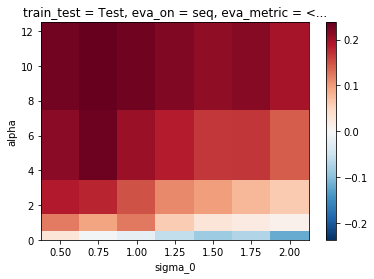

In [15]:
result_pkl[1][1][1].mean(axis = -1).mean(axis = -1).plot()